In [6]:
from pathlib import Path
import logging
import json
from typing import *
import time
from datetime import datetime
import warnings

from tqdm import tqdm
import pandas as pd
import numpy as np
from PIL import Image, ImageFile

import torch
import torch.nn as nn
import torchvision.transforms as T
from lavis.models import load_model_and_preprocess, BlipBase
from lavis.processors import load_processor
import torch.nn.functional as F
from transformers import get_cosine_schedule_with_warmup
from transformers import BatchEncoding

from src.data import CustomSplitLoader, ImageSet
from src.itm import DefaultDataset, AltNSDataset, to_device, ITMClassifier

from src.utils import evaluate, mrr
from src.validation import Validation, sum_scores, div_scores, eval_batch, metric2name
from sklearn.metrics import top_k_accuracy_score
from torch.utils.tensorboard import SummaryWriter


In [7]:
id2task = {"pi_t": "Positive image to Context", "ni_t": "Negative image to Context", "pi_ni": "Positive image to Negative image"}

In [8]:
dfs = {
    "Positive proba #itm28": pd.read_json("/home/s1m00n/research/vwsd/data/train_v1/itm28-pos-preds.json"),
    "Negative proba #itm28": pd.read_json("/home/s1m00n/research/vwsd/data/train_v1/itm28-neg-preds.json"),
    "Positive proba #itm0": pd.read_json("/home/s1m00n/research/vwsd/data/train_v1/itm0-pos-preds.json"),
    "Negative proba #itm0": pd.read_json("/home/s1m00n/research/vwsd/data/train_v1/itm0-neg-preds.json"),
}

In [11]:
for df_name, df in dfs.items():
    for task in ["pi_t", "ni_t"]:
        series = df.loc[task] # series of lists
        for set_name in ["train_dl", "train_dl2", "val_dl", "val2_dl", "test_dl", "test2_dl"]:
            arr = np.array(series[set_name])
            task_name = id2task[task]
            print(f"Predictor: {df_name}; Task: {task_name}; Set: {set_name}")
            mean = np.mean(arr)
            std = np.std(arr)
            print(f"    => mean: {mean}, std: {std}")

Predictor: Positive proba #itm28; Task: Positive image to Context; Set: train_dl
    => mean: 4.4463117149181315, std: 4.1689563447307325
Predictor: Positive proba #itm28; Task: Positive image to Context; Set: train_dl2
    => mean: 4.4463117149181315, std: 4.1689563447307325
Predictor: Positive proba #itm28; Task: Positive image to Context; Set: val_dl
    => mean: 4.46757243778065, std: 4.173277748839401
Predictor: Positive proba #itm28; Task: Positive image to Context; Set: val2_dl
    => mean: 4.43943462878274, std: 4.183963732141808
Predictor: Positive proba #itm28; Task: Positive image to Context; Set: test_dl
    => mean: 4.461399828150416, std: 4.176106840748487
Predictor: Positive proba #itm28; Task: Positive image to Context; Set: test2_dl
    => mean: 4.430088233921947, std: 4.195761579812819
Predictor: Positive proba #itm28; Task: Negative image to Context; Set: train_dl
    => mean: -6.863547634028069, std: 1.461234069516176
Predictor: Positive proba #itm28; Task: Negative

/tmp/ipykernel_1114014/2410431272.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


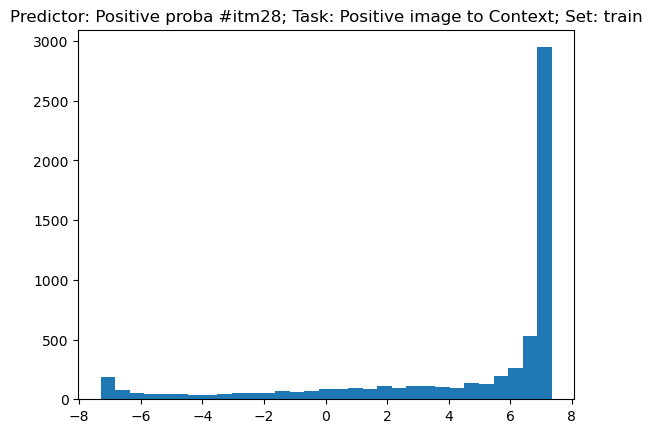

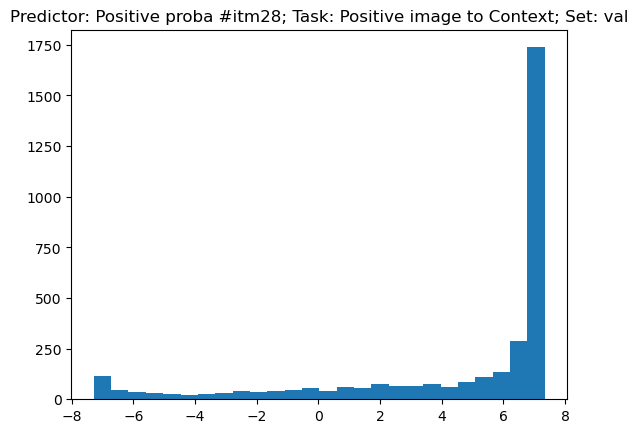

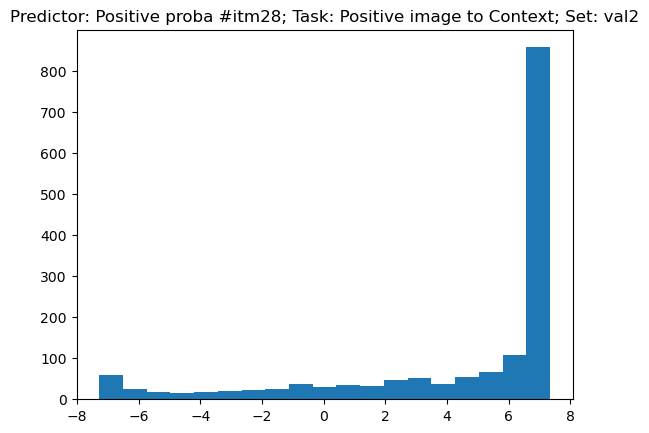

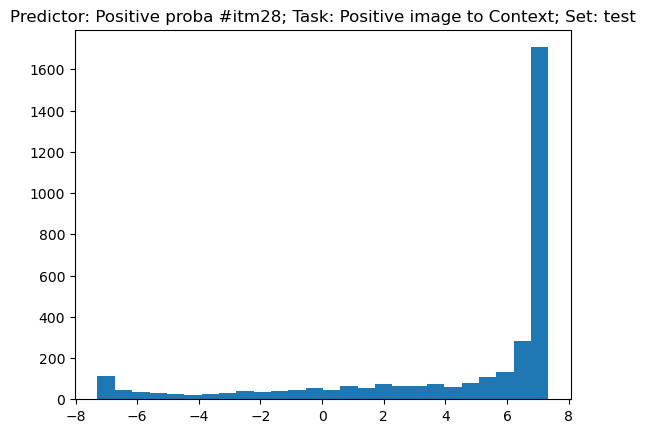

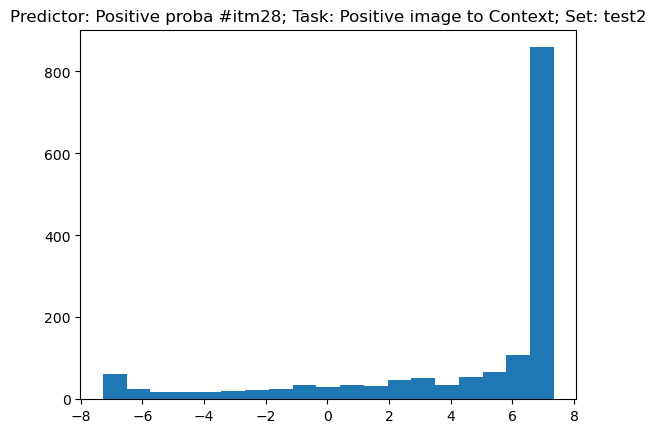

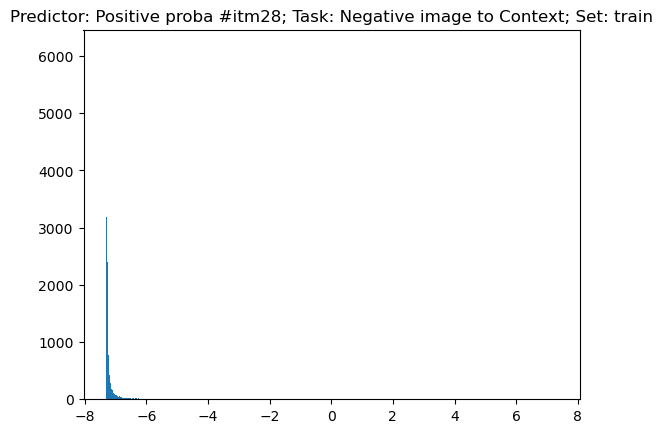

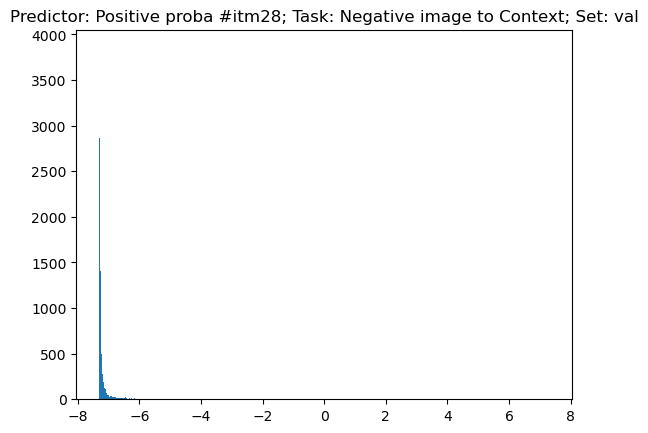

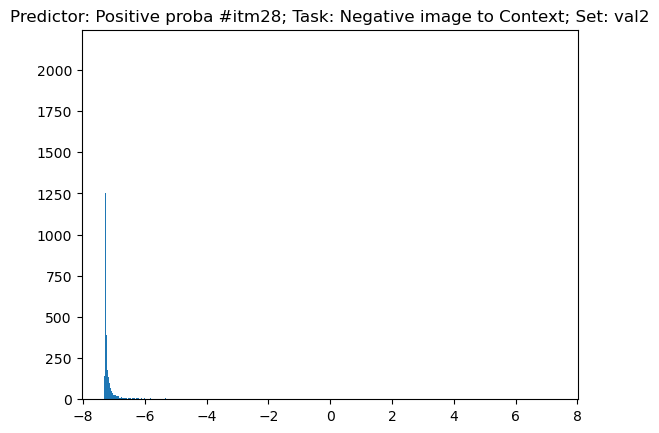

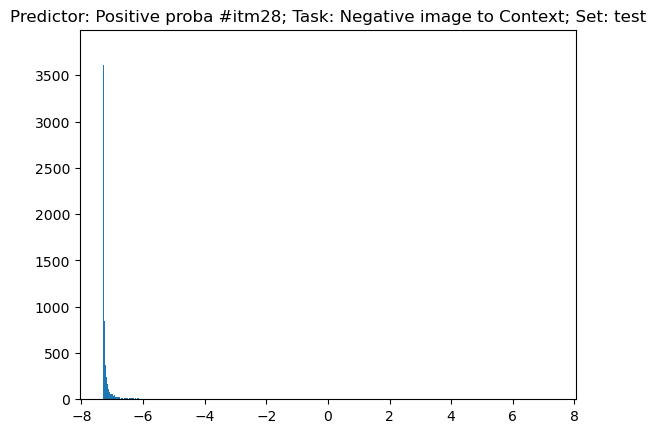

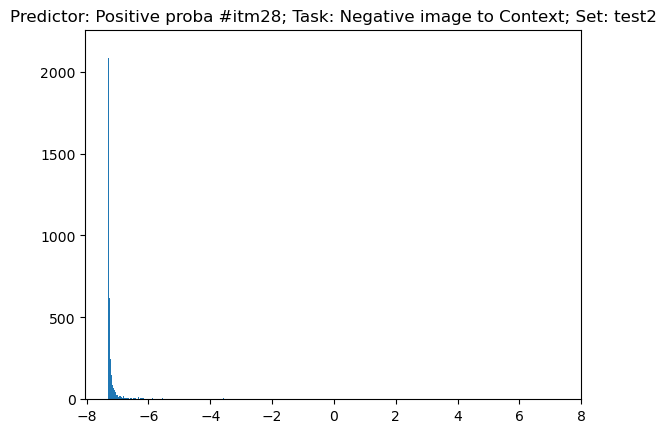

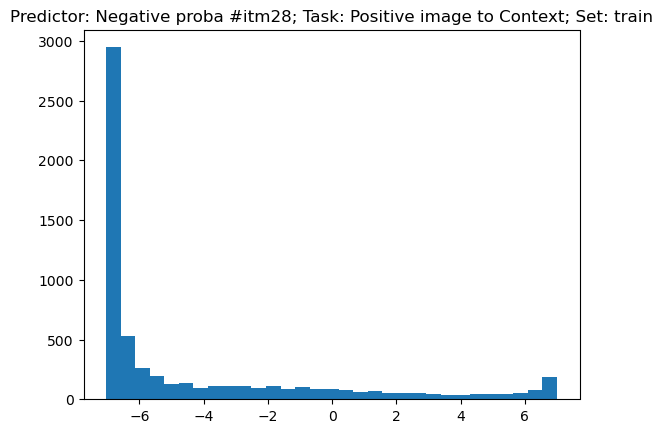

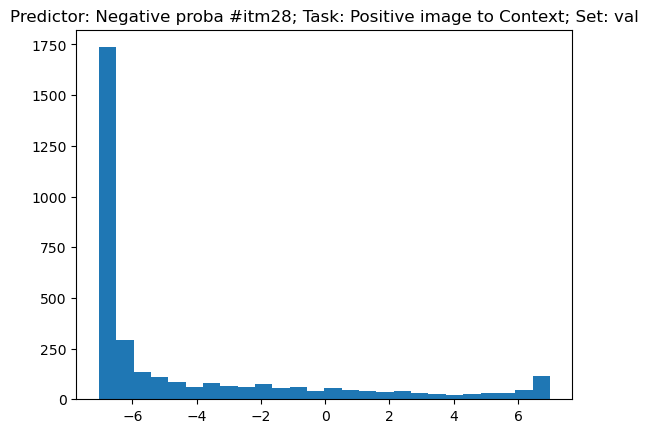

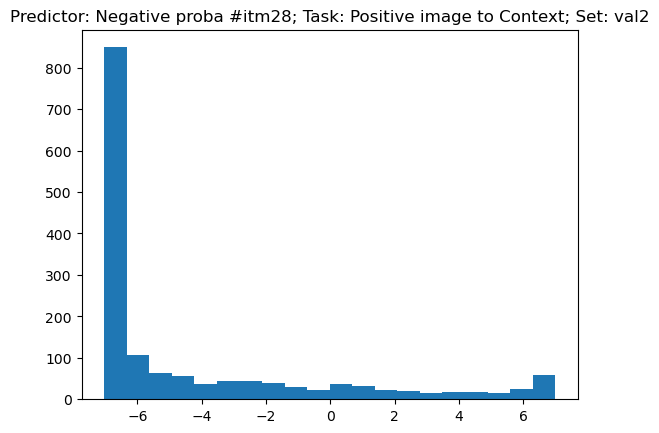

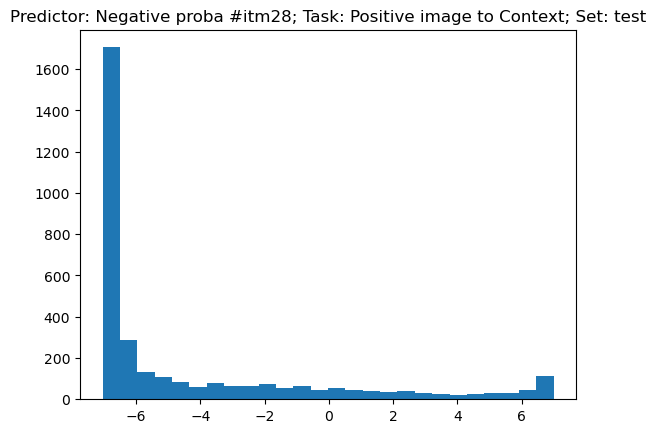

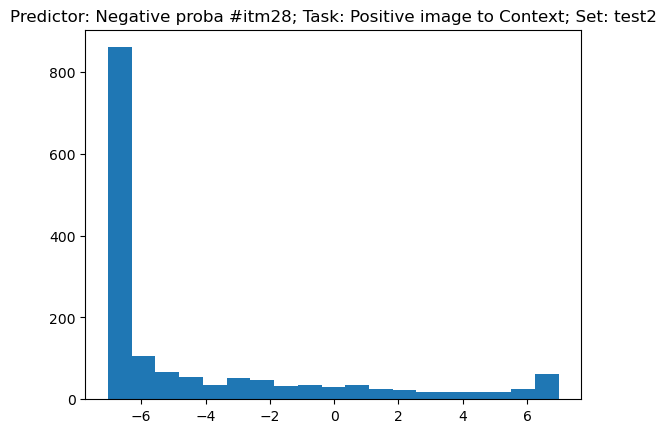

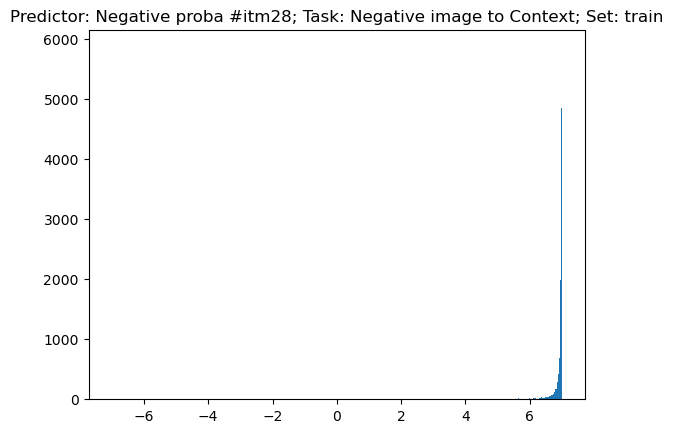

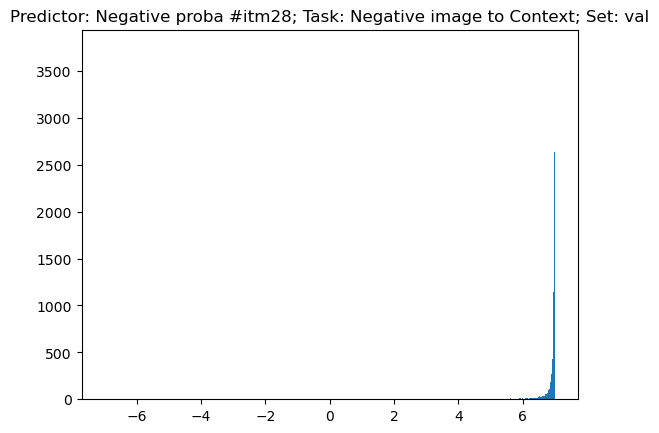

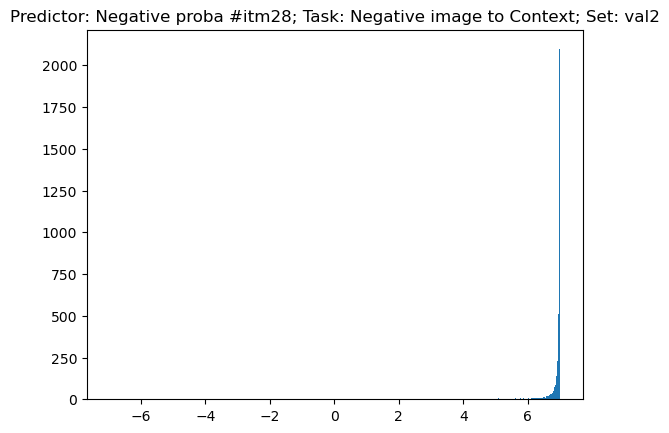

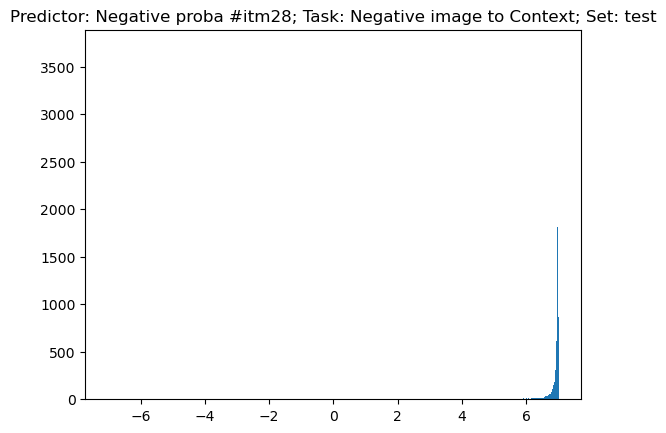

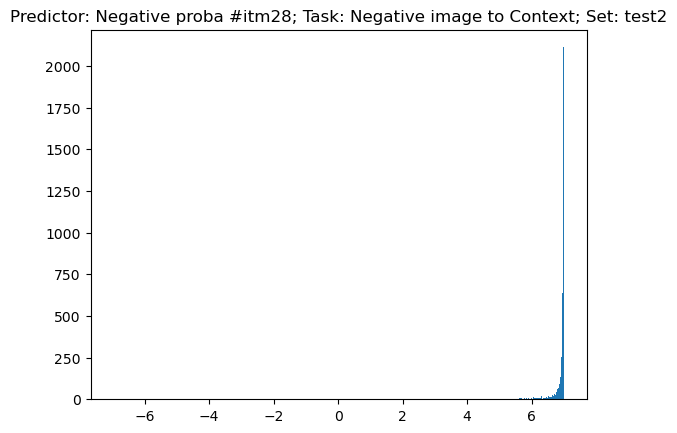

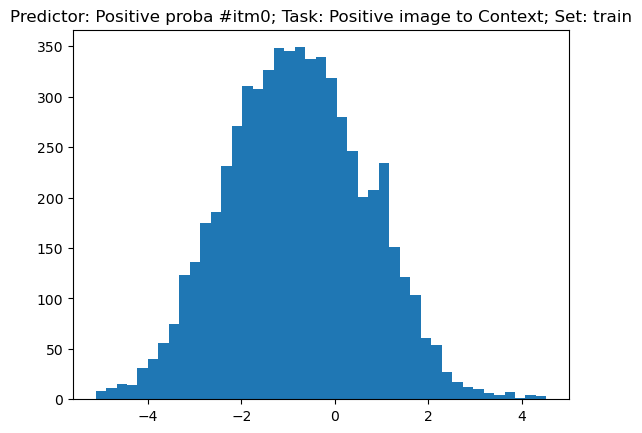

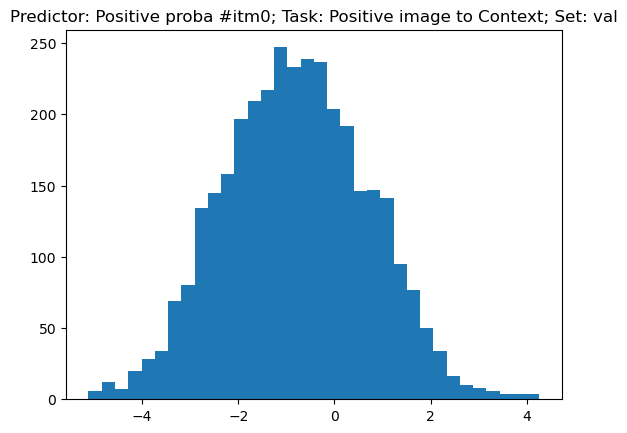

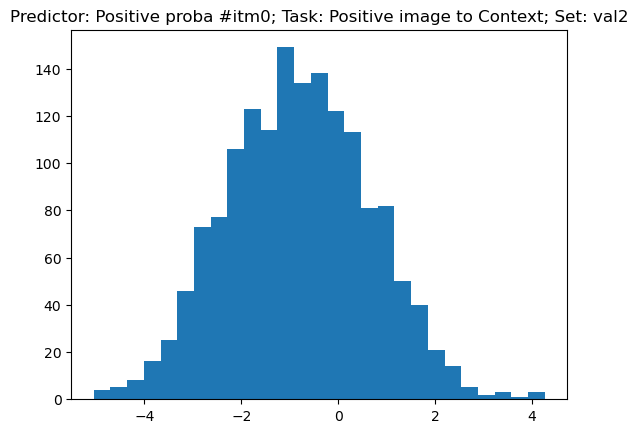

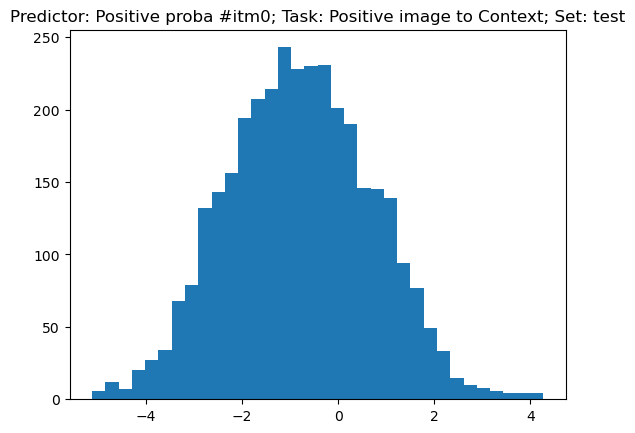

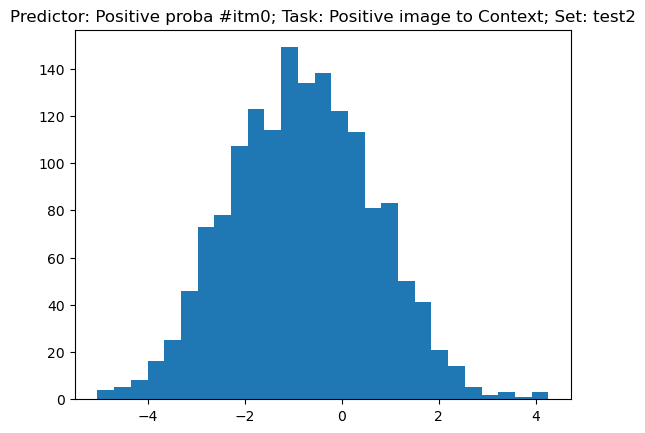

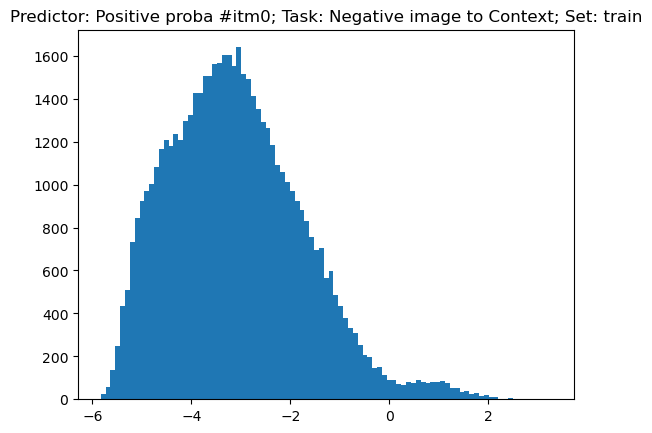

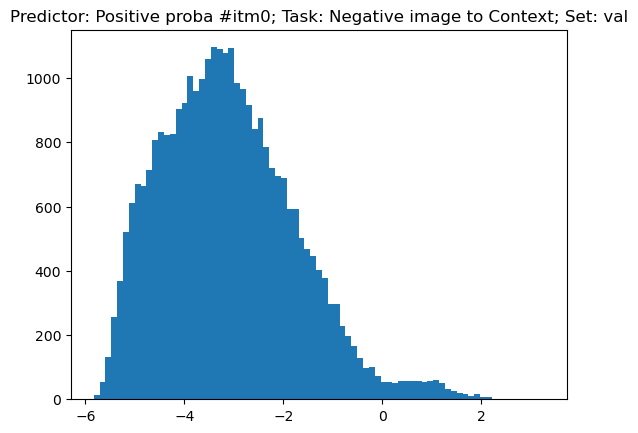

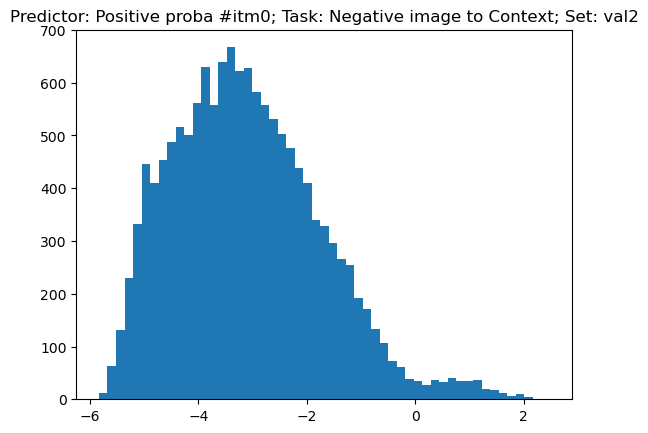

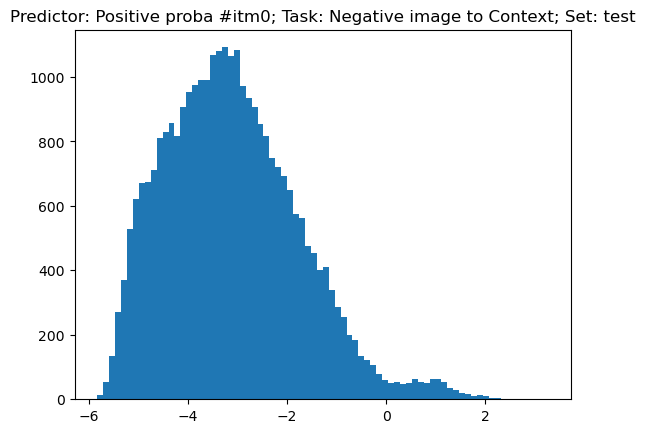

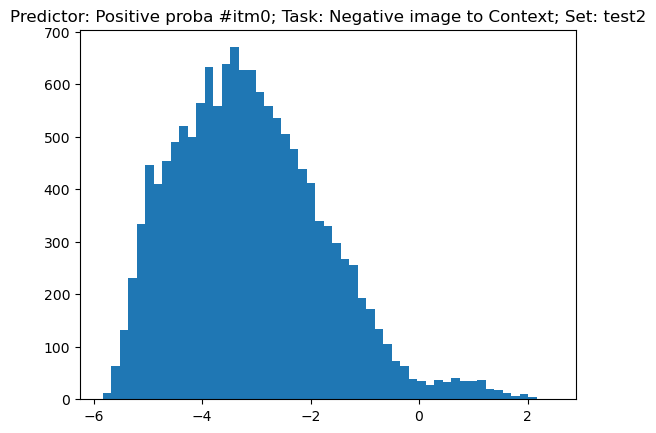

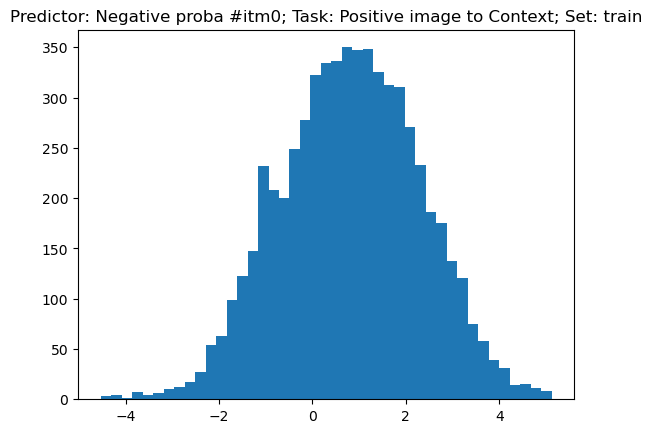

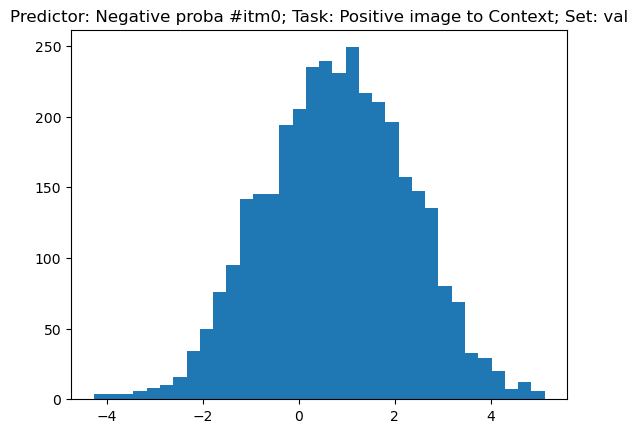

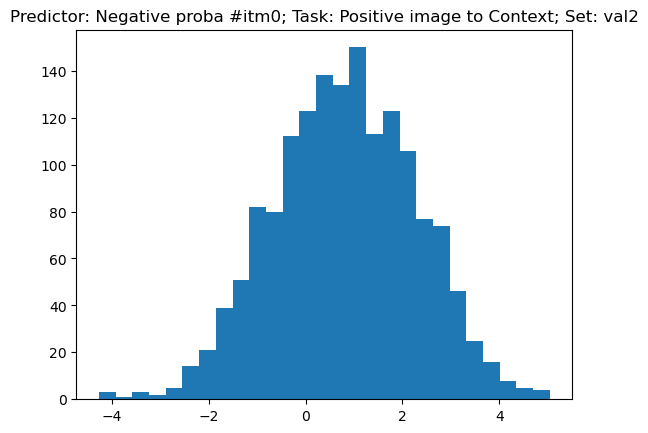

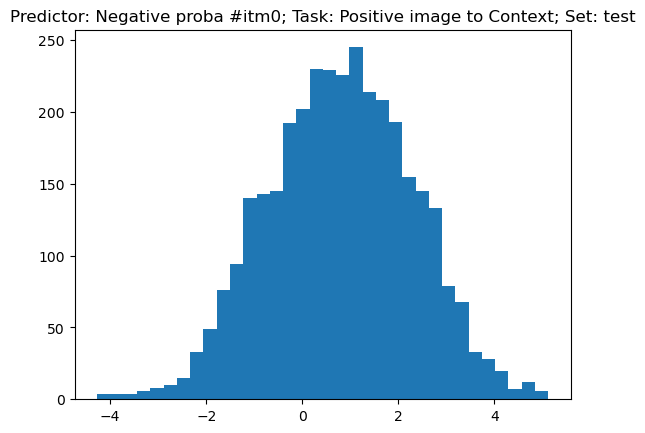

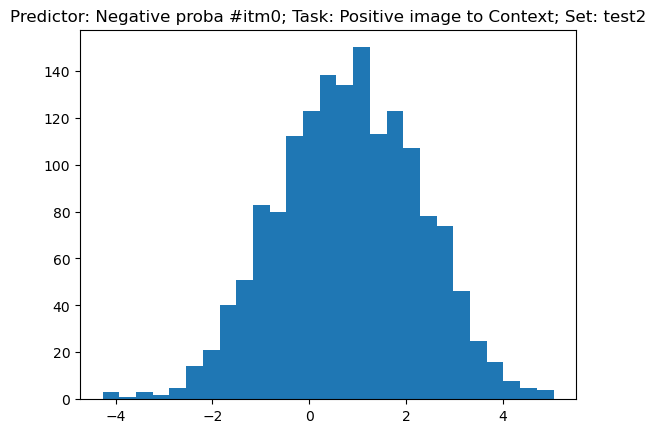

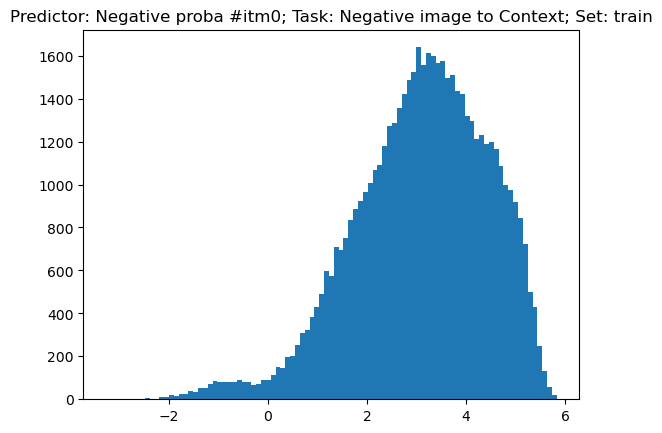

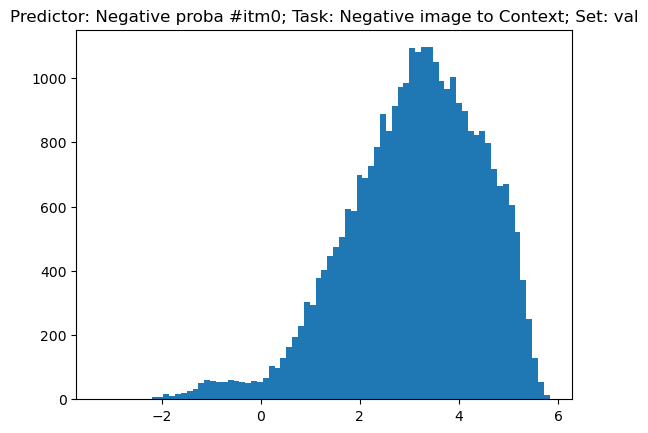

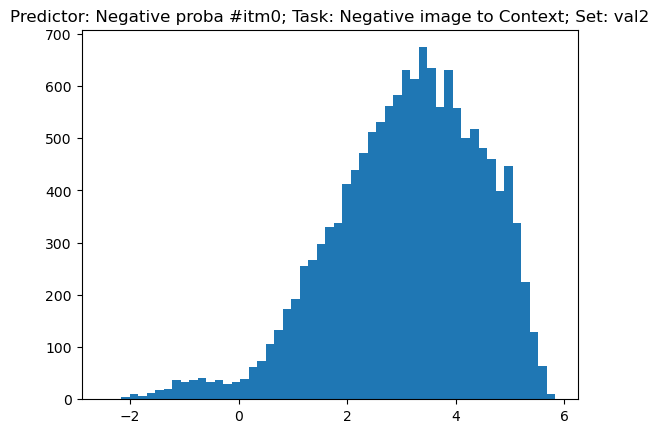

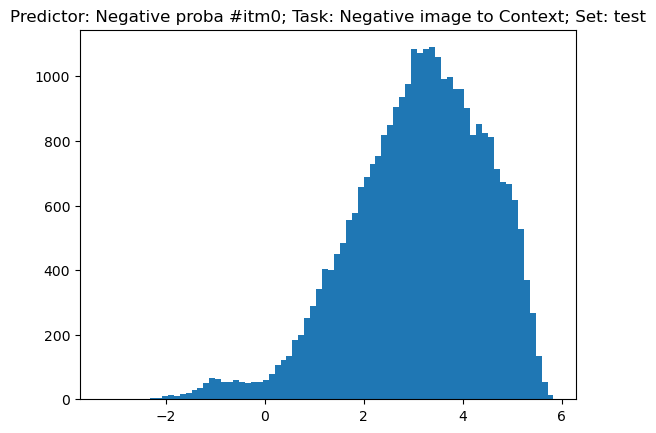

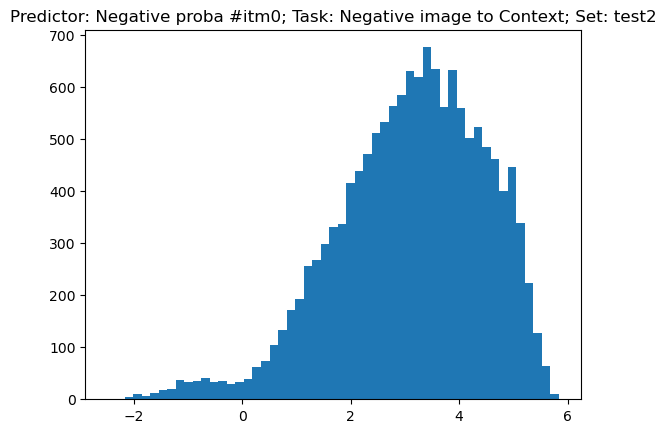

<Figure size 640x480 with 0 Axes>

In [10]:
for df_name, df in dfs.items():
    for task in ["pi_t", "ni_t"]:
        series = df.loc[task] # series of lists
        for set_name in ["train_dl", "train_dl2", "val_dl", "val2_dl", "test_dl", "test2_dl"]:
            arr = np.array(series[set_name])
            task_name = id2task[task]
            plt.title(f"Predictor: {df_name}; Task: {task_name}; Set: {set_name}")
            plt.hist(arr, bins="auto") 
            plt.figure()